# Cross Phase Modulation Simulations

This simulation is a step up from the quantum memory simulations with a full 4 level atomic system (no approximations made to simplify the set of equations) with three of the levels forming the quantum memory Raman transition and a 4th level addressed with the Stark shifting beam providing a phase shift to the state stored in the quantum memory.  

To obtain the phase shift obtained as a result of the Stark shifting beam, the imaginary component of the recalled electric field is extracted.  The size of this phase shift is obtained for a series of Stark pulse energies.  

Though not necessary for running the simulations, below also includes experimental data of phase shift and memory efficiency as a function of Stark energy (to compare with simulation data)

In [2]:
import subprocess
import pandas as pd
import h5py
import numpy as np
import csv
import json
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from time import sleep
import xml.dom.minidom as xmlmd
from IPython.display import Audio
from scipy.ndimage.filters import uniform_filter1d

#Sound files to indicate when simulation loop has succeeded or encountered an error
sound_file = './beep.wav'
errsound_file = './errorsound.wav'

#Files containing experimental data for phase shift and memory efficiency for a series of Stark energies
data = pd.read_csv('energy_phase_data.csv')
energy = data['Stark Energy (J)']
shift = data['Phase shift']
energyerror = data['Stark Energy error (J)']
shifterror = data['Phase shift error']
dataeff = pd.read_csv('energy_eff_data.csv')
energyeff = dataeff['Stark Energy (J)']
eff = dataeff['Efficiency']

#Function for passing user determined parameters to be executed in simulation
def set_params(xml_args, arg_dict):
    for k in arg_dict.keys():
        for arg in xml_args:
            arg_name = arg.getAttribute("name")
            if arg_name == k:
                arg.setAttribute("default_value", arg_dict[k])

#This class contains a number of useful functions for conveniently extracting information from the output h5 files;
#A lot of the functions here can be written better but they work for now...
class plotter:
    def __init__(self):
        evalues = np.linspace(0,0.25,3)
        domain = np.round(evalues**0.5,4)
        self.filename = ("./1DXPM4Lunpurefine_ML.h5") #!!!IMPORTANT: change the name in brackets here to match the h5 filename        
                             
    def extract(self,parameter): #Extracts the chosen parameter
        f = h5py.File(self.filename,'r')
        array = np.zeros(f['1']['{parameter}I'.format(parameter=parameter)].shape, dtype=complex)
        array.real = f['1']['{parameter}R'.format(parameter=parameter)]
        array.imag = f['1']['{parameter}I'.format(parameter=parameter)]
        f.close()
        return array
    def t(self): #Extracts the time arroy defined in the xmds file
        f = h5py.File(self.filename,'r')
        time = np.array(f['1']['t'])
        f.close()
        return time
    def z(self): #Extracts the spatial z array defined in xmds file
        f = h5py.File(self.filename,'r')
        z = np.array(f['1']['z'])
        f.close()
        return z
    #Array plots:
    def norplot(self,parameter): #array without subtracting initial conditions, FLIPS Z coordinates
        array = self.extract(parameter)
        return np.flip(np.transpose(np.abs(array)**2),0)
    def calplot(self,parameter): #array with subtracting initial conditions at z = 1, FLIPS Z coordinates
        array = self.extract(parameter)
        arrayinit = np.transpose(np.tile(np.array(array[:,1]),(100,1)))
        return np.flip(np.transpose(np.abs(array)**2 - np.abs(arrayinit)**2),0)
    
    #Plots the time variation at a given z coordinate (FLIPS Z coordinates)
    def norzslice(self,parameter,z,t=None): #Taking z slice for norplot
        if t == None:
            return self.norplot(parameter)[z,:]
        else:
            return self.norplot(parameter)[z,t]
    def zslice(self,parameter,z, t=None): #Taking z slice for calplot
        if t == None:
            return self.calplot(parameter)[z,:]
        else:
            return self.calplot(parameter)[z,t]
    
    #Computes single values out of the data
    def norzint(self,parameter,z,t1,t2): #Integrates a z slice; can be used to integrate for pulse energy 
        return np.sum(self.norplot(parameter)[z,t1:t2])
    
    def phase(self, parameter, z, t=None,t2=None): #Extracts phase of a field
        if t == None:
            return np.angle(self.extract(parameter)[:,z])
        else:
            if t2 == None:
                return np.angle(self.extract(parameter)[t,z])
            else:
                return np.mean(np.angle(self.extract(parameter)[t:t2,z]))



/tmp/ipykernel_22/701746317.py:12: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


  0%|          | 0/10 [00:00<?, ?it/s]

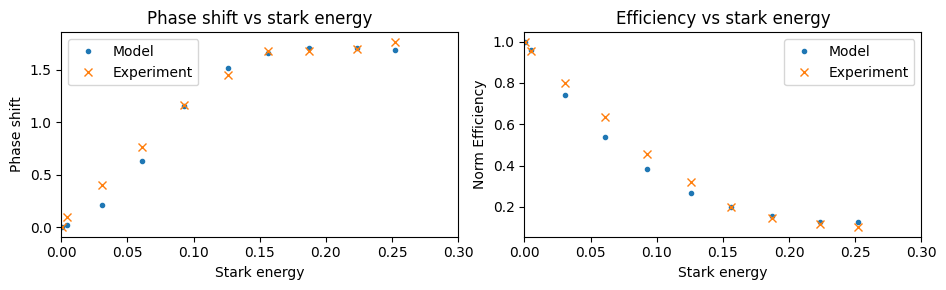

In [3]:
file = '1DXPM4Lunpurefine_ML'
evalues = np.array((energy*1e12)/40) #Converts energy values from the experimental csv data to Stark Rabi frequency^2
domain = np.round(evalues**0.5,4)

#Initializing phase and efficiency value arrays
phasearray = []
effarray = []

timeout = False

#All the following parameter values have been optimized by a machine learner
tin = round(3002.90556420481) 
tend = round(3145.699810672175)
for i, value in enumerate(tqdm(domain)):
    # Setting the simulation parameters
    arg_dict = {'tin'       :'3' ,
                'pulsewidth':'12' ,
                'bandwidth' :'0.010094884707674433'   ,
                'omega_in'  :'2'   ,
                'delta_in'  :'-247.84044512213825' ,
                'od'        :'50',
                'amp'       :'0.000010458809779082506',
                'omegas_in' :str(value),
                'deltas_in' :'-8.7',
                'slength'   :'5',
                'purity'    :'0.9824651752020224',
                's_focus'   :'0.7906765533901071',
                's_norm'    :'1.3533653401938281'
                }
    # Open xml for parsing
    doc = xmlmd.parse('./' + file + '.xmds')
    # get all arguments
    args = doc.getElementsByTagName('argument')
    # set the new parameters
    set_params(args, arg_dict)
    #open the file and write it
    new_file = open('./sim_files/' + file + '.xmds', 'w+')
    doc.writexml(new_file)
    new_file.close()
    subprocess.run(['xmds2', './sim_files/' + file + '.xmds'], capture_output=True);
    try:
        subprocess.run(['./' + file], capture_output=True, timeout=50); #This timeout value can be increased if your simulations take longer
    except subprocess.TimeoutExpired:
        Audio(errsound_file, autoplay=True)
        print('Oops timeout Value '+str(i))
        phasearray.append(10000)
        effarray.append(10000)
        timeout = True
        break
    #Adding values to phase array
    phasearray.append(plotter().phase('E',-1,tin,tend))
    #Adding values to efficiency array
    effarray.append(plotter().norzint('E',0,1600,3200)/plotter().norzint('E',-1,0,3200))

phasearray = -(phasearray-phasearray[0]) #Subtracts out the initial phase so only phase due to stark shift is shown
effarray = (effarray/effarray[0])**2     #Squares efficiency to obtain efficiency for stored energy rather than amplitude

#Plots the phase and energy along with experimental data
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9.5,3))
ax.plot(evalues,phasearray,'.',label='Model')
ax.plot((energy*1e12)/40,shift,'x',label='Experiment')
ax.set_title('Phase shift vs stark energy')
ax.set_xlabel('Stark energy')
ax.set_ylabel('Phase shift')
ax2.plot(evalues,effarray,'.',label='Model')
ax2.plot((energy*1e12)/40,eff/eff[0],'x',label='Experiment')
ax2.set_title('Efficiency vs stark energy')
ax2.set_xlabel('Stark energy')
ax2.set_ylabel('Norm Efficiency')
plt.tight_layout()
ax.set_xlim([0,0.30])
ax2.set_xlim([0,0.30])
ax.legend()
ax2.legend()
plt.show()


Audio(sound_file, autoplay=True)